In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error

In [26]:
df = pd.read_csv('Daily+temperature+data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [27]:
df.head(34)

,Temperature(Min)
Date,
2017-01-01,14.3
2017-01-02,17.4
2017-01-03,18.5
2017-01-04,16.8
2017-01-05,11.5
2017-01-06,9.5
2017-01-07,12.2
2017-01-08,15.7
2017-01-09,16.3


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2017-01-01 to 2018-12-31
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Temperature(Min)  730 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


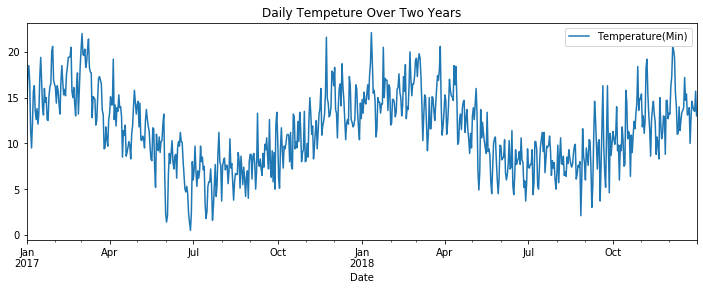

In [32]:
df.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Daily Tempeture Over Two Years')
plt.show(block=False)

## Outlier detection

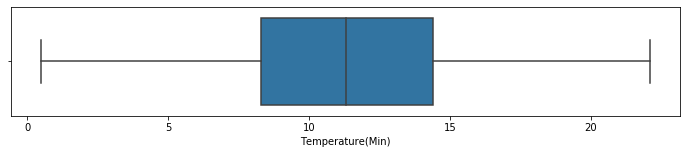

In [36]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=df['Temperature(Min)'],whis=1.5)

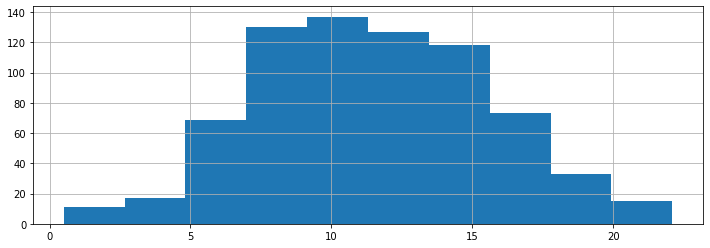

In [37]:
fig = df['Temperature(Min)'].hist(figsize = (12,4))

# Build and evaluate time series forecast

## Split time series data into training and test set

In [38]:
train_len = 511
train = df[0:train_len] # first 120 months as training set
test = df[train_len:] # last 24 months as out-of-time test set

In [41]:
365*2 - 511

219

# Exponential smoothing methods

## Simple exponential smoothing

In [54]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Temperature(Min)'])
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(219)

/Users/richasharma/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [55]:
model_fit.params

{'smoothing_level': 0.2,
 'smoothing_slope': None,
 'smoothing_seasonal': None,
 'damping_slope': nan,
 'initial_level': 14.3,
 'initial_slope': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

### Plot train, test and forecast

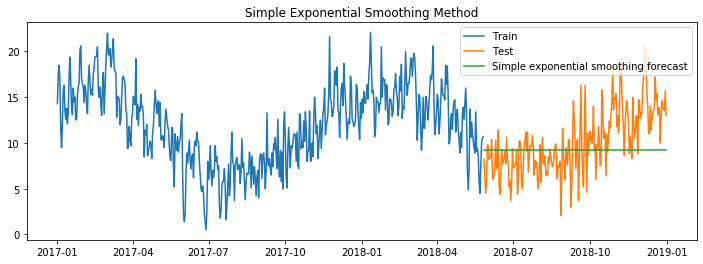

In [56]:
plt.figure(figsize=(12,4))
plt.plot(train['Temperature(Min)'], label='Train')
plt.plot(test['Temperature(Min)'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

### Calculate RMSE and MAPE

In [57]:
rmse = np.sqrt(mean_squared_error(test['Temperature(Min)'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Temperature(Min)']-y_hat_ses['ses_forecast'])/test['Temperature(Min)'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
tempResults

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,3.56,30.24


## Holt's method with trend

In [58]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Temperature(Min)']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.5, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.5, 'smoothing_slope': 0.01, 'smoothing_seasonal': None, 'damping_slope': nan, 'initial_level': 14.3, 'initial_slope': 3.099999999999998, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

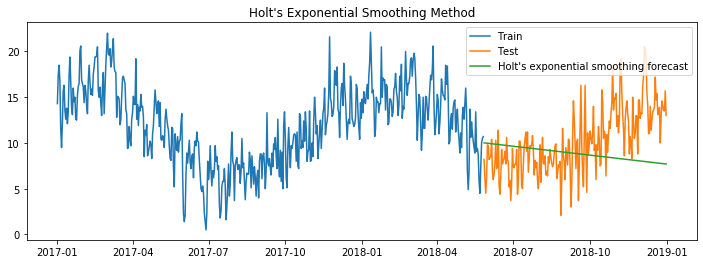

In [59]:
plt.figure(figsize=(12,4))
plt.plot( train['Temperature(Min)'], label='Train')
plt.plot(test['Temperature(Min)'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

### Calculate RSME and MAPE

In [62]:
rmse = np.sqrt(mean_squared_error(test['Temperature(Min)'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Temperature(Min)']-y_hat_holt['holt_forecast'])/test['Temperature(Min)'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
tempResults

,Method,RMSE,MAPE
0,Holt's exponential smoothing method,4.11,34.17


## Holt Winters' additive method with trend and seasonality

In [63]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Temperature(Min)']) ,seasonal_periods=30 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.6745630227755732, 'smoothing_slope': 9.097068409464451e-26, 'smoothing_seasonal': 4.105703238534659e-25, 'damping_slope': nan, 'initial_level': 12.384605595999334, 'initial_slope': 1.7109610688503448e-23, 'initial_seasons': array([3.06522013, 2.57165523, 2.59368224, 3.10381382, 2.57836622,
       2.39973838, 2.50911104, 3.15955761, 3.31016579, 2.99036774,
       3.070814  , 2.81595011, 1.82005577, 2.77113242, 2.96936717,
       2.99693904, 1.94799156, 2.75777592, 2.45572752, 1.77710756,
       1.99842438, 2.83141103, 1.65845736, 0.96227508, 1.82490976,
       1.82903781, 2.09785003, 2.7138174 , 3.22976833, 3.24610929]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

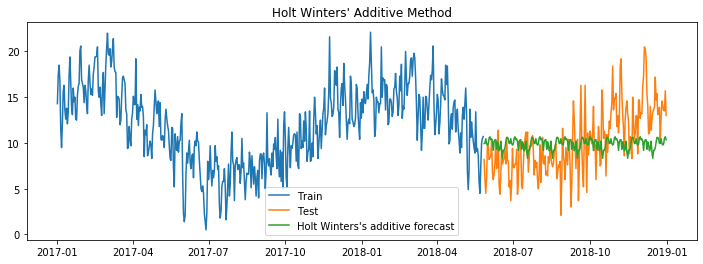

In [64]:
plt.figure(figsize=(12,4))
plt.plot( train['Temperature(Min)'], label='Train')
plt.plot(test['Temperature(Min)'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

### Calculate RMSE and MAPE

In [65]:
rmse = np.sqrt(mean_squared_error(test['Temperature(Min)'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Temperature(Min)']-y_hat_hwa['hw_forecast'])/test['Temperature(Min)'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
tempResults

,Method,RMSE,MAPE
0,Holt Winters' additive method,3.5,32.83
